In [1]:
#Downloading data
!wget https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2024-03-28 14:06:06--  https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: 'SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'

SingleElectronPt50_ 100%[===================>] 122.95M  25.8MB/s    in 5.7s    

2024-03-28 14:06:19 (21.5 MB/s) - 'SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5' saved [128927319/128927319]

--2024-03-28 14:06:20--  https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awai

In [2]:
#Importing required packages
import os
import tensorflow as tf
import h5py
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input,Activation, AveragePooling2D, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
warnings.filterwarnings("ignore")

2024-03-28 14:06:34.339324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 14:06:34.339424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 14:06:34.493342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
f = h5py.File("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
g = h5py.File("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
electron = np.asarray(f['X'])
photon = np.asarray(g['X'])
channel1_elect = (electron[:,:,:,0] - electron[:,:,:,0].min())/(electron[:,:,:,0].max() - electron[:,:,:,0].min()) 
channel2_elect = (electron[:,:,:,1] - electron[:,:,:,1].min())/(electron[:,:,:,1].max() - electron[:,:,:,1].min())
channel1_phot = (photon[:,:,:,0] - photon[:,:,:,0].min())/(photon[:,:,:,0].max() - photon[:,:,:,0].min()) 
channel2_phot = (photon[:,:,:,1] - photon[:,:,:,1].min())/(photon[:,:,:,1].max() - photon[:,:,:,1].min())
channel1_elect_reshaped = np.reshape(channel1_elect, (-1, (32*32)))
channel2_elect_reshaped = np.reshape(channel2_elect, (-1, (32*32)))
channel1_phot_reshaped = np.reshape(channel1_phot, (-1, (32*32)))
channel2_phot_reshaped = np.reshape(channel2_phot, (-1, (32*32)))
elect_reshaped = np.concatenate([channel1_elect_reshaped,channel2_elect_reshaped], axis = -1)
phot_reshaped = np.concatenate([channel1_phot_reshaped,channel2_phot_reshaped], axis = -1)
elect_reshaped = elect_reshaped * 255
phot_reshaped = phot_reshaped * 255
elect_reshaped = elect_reshaped.astype(np.uint8)
phot_reshaped = phot_reshaped.astype(np.uint8)
electron_clean = np.zeros((elect_reshaped.shape[0],2049) ,dtype = np.uint8 )
photon_clean = np.zeros((phot_reshaped.shape[0],2049) ,dtype = np.uint8 )
electron_clean[:,2048] = 1
photon_clean[:,2048] = 0
electron_clean[:,:2048] = elect_reshaped
photon_clean[:,:2048] = phot_reshaped
X = np.concatenate([electron_clean[:,:-1], photon_clean[:,:-1]], axis=0)
y = np.concatenate([electron_clean[:,-1], photon_clean[:,-1]], axis=0)

In [4]:
#Shuffling the data
X=X.reshape(498000,32,32,2)
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)
a=10
for i in range(10):
    X, y = shuffle(X, y, random_state=a)
    a=a+20

In [5]:
#model
def resnet15_block(x, filters, dropout_rate):
    shortcut = x
    
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    return x


input_layer = Input(shape=(32, 32, 2))

x = Conv2D(16, (7, 7), padding='same')(input_layer)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Conv2D(32, (1, 1), strides=(1, 1), padding='same')(x)
x = Activation('relu')(x)
x = resnet15_block(x, 32, dropout_rate=0.001)
x = resnet15_block(x, 32, dropout_rate=0.001)
x = resnet15_block(x, 32, dropout_rate=0.001)
x = Flatten()(x)
x = Dense(64)(x)
x = Dropout(0.01)(x)
x = Dense(64)(x)
x = Dropout(0.02)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

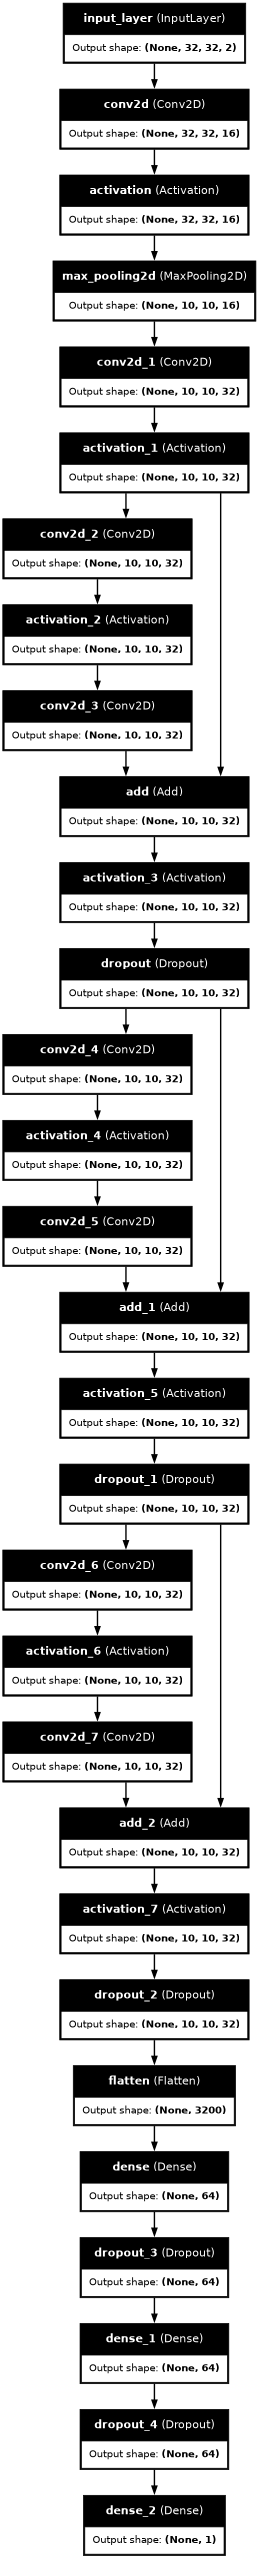

In [6]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=50)


In [7]:
#CALLBACKS
rd_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001
)
callbacks = [rd_lr]

#COMPILING THE MODEL
model.compile(
    optimizer=tf.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)
history = model.fit(
    X, y,  
    batch_size=80,
    epochs=20,
    validation_split=0.2, 
    callbacks=callbacks
)

Epoch 1/20
  24/4980 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.4881 - auc: 0.4897 - loss: 101.5682

I0000 00:00:1711634850.563468      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711634850.587264      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4972/4980 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6364 - auc: 0.6777 - loss: 2.2479

W0000 00:00:1711634871.923811      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4980/4980 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.6365 - auc: 0.6778 - loss: 2.2453 - val_accuracy: 0.7073 - val_auc: 0.7622 - val_loss: 0.5846 - learning_rate: 0.0010
Epoch 2/20
4980/4980 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7048 - auc: 0.7579 - loss: 0.5848 - val_accuracy: 0.7119 - val_auc: 0.7726 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 3/20
4980/4980 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7124 - auc: 0.7687 - loss: 0.5745 - val_accuracy: 0.7141 - val_auc: 0.7714 - val_loss: 0.5747 - learning_rate: 0.0010
Epoch 4/20
4980/4980 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7176 - auc: 0.7754 - loss: 0.5683 - val_accuracy: 0.7212 - val_auc: 0.7799 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 5/20
4980/4980 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7206 - auc: 0.7788 - loss: 0.5646 - val_accuracy: 0.7198 - val_auc: 0.7829 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 6/20
4980/4980 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7225 - 

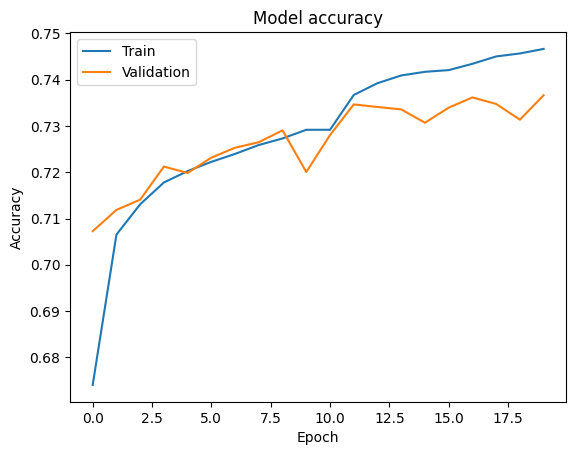

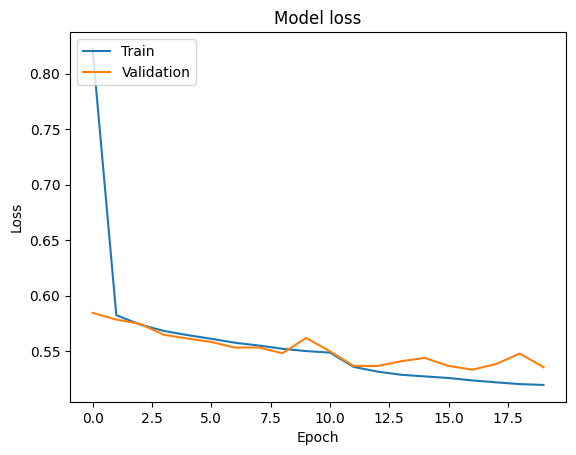

In [8]:
#PLOTS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()